In [1]:
# https://en.m.wikipedia.org/wiki/List_of_majority-minority_United_States_congressional_districts
state = 'IL'    # 2-letter state code
level = 'tract' # county, tract, block

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    
    # voting age population (VAP)
    G.nodes[node]['VAP'] = G.nodes[node]['P0040001']
    
    # Hispanic or Latino VAP
    G.nodes[node]['HVAP'] = G.nodes[node]['P0040002']

In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
from number_of_districts import congressional_districts_2020
k = congressional_districts_2020[state]

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749909 and U = 757445 and k = 17


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i] equals one when tract i is selected
x = m.addVars(G.nodes, vtype=GRB.BINARY)  

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-27


In [5]:
# get county graph too
filename = state + '_county.json'
GC = Graph.from_json( filepath + filename )

for node in GC.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    GC.nodes[node]['TOTPOP'] = GC.nodes[node]['P0010001']

gtn = { GC.nodes[i]['GEOID20'] : i for i in GC.nodes }

In [6]:
# y[u,v] equals one when arc (u,v) is cut because u but not v is selected
y = m.addVars(DG.edges, vtype=GRB.BINARY) 

# z is inverse Polsby-Popper score for district 
z = m.addVar()

# A = area of district 
A = m.addVar()

# P = perimeter of district 
P = m.addVar()

In [7]:
# objective is to minimize inverse Polsby-Popper score
m.setObjective( z, GRB.MINIMIZE )

In [8]:
# add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
m.addConstr( P * P <= 4 * math.pi * A * z )

# add constraint on area A 
m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

# add constraint on perimeter P
m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [9]:
# add constraints saying that district has population at least L and at most U
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

# add constraints saying that arc (u,v) is cut if u but not v is selected
m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )

m.update()

In [10]:
hvap = m.addVar()
vap = m.addVar()

m.addConstr( hvap == gp.quicksum( G.nodes[i]['HVAP'] * x[i] for i in G.nodes ) )
m.addConstr( vap == gp.quicksum( G.nodes[i]['VAP'] * x[i] for i in G.nodes ) )

m.addConstr( hvap >= 0.5 * vap )

<gurobi.Constr *Awaiting Model Update*>

In [11]:
# solve IP model
m.Params.TimeLimit = 3600
m.optimize()

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17463 rows, 20726 columns and 86284 nonzeros
Model fingerprint: 0xb3da2854
Model has 1 quadratic constraint
Variable types: 5 continuous, 20721 integer (20721 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 8e+05]
Presolve time: 0.19s
Presolved: 17463 rows, 20726 columns, 86284 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 20723 integer (20721 binary)

Root relaxation: objective 0.000000e+00, 1749 iterations, 0.10 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0               

  1262  1048    0.67053   13 1500    1.38364    0.17795  87.1%   717 1007s
  1266  1048    0.18072   14 2484    1.38364    0.17811  87.1%   720 1012s
  1271  1048    0.92740   14 1272    1.38364    0.18072  86.9%   726 1024s
  1275  1049    0.18525   15 2642    1.38364    0.18280  86.8%   729 1030s
  1279  1052    0.81735   15 1166    1.38364    0.18526  86.6%   735 1037s
  1290  1055    0.77051   16 2011    1.38364    0.18801  86.4%   742 1054s
  1296  1055    0.19117   17 2617    1.38364    0.19117  86.2%   743 1070s
  1302  1052    0.19489   18 2865    1.38364    0.19118  86.2%   754 1077s
  1309  1053    0.20610   18 2247    1.38364    0.19489  85.9%   759 1087s
  1313  1058    0.20311   19 2918    1.38364    0.20311  85.3%   763 1097s
  1319  1060    0.21676   20 2819    1.38364    0.20574  85.1%   766 1104s
  1325  1064    0.72939   20 1875    1.38364    0.20612  85.1%   773 1122s
  1331  1067    0.22248   21 2770    1.38364    0.20612  85.1%   774 1140s
  1336  1068    0.23067  

In [12]:
print("The inverse PP score is",m.objval)
print("The PP score is",1.0/m.objval)

# retrieve the district and population
district = [i for i in G.nodes if x[i].x > 0.5] 
district_population = sum( G.nodes[i]["TOTPOP"] for i in district )

The inverse PP score is 1.3836381774671185
The PP score is 0.7227322982881228


In [13]:
print("hispanic_vap =", round(hvap.x) )
print("total_vap =", round(vap.x) )
print("percentage =", round( 100 * hvap.x / vap.x ),"%" )

hispanic_vap = 295865
total_vap = 569877
percentage = 52 %


In [14]:
# Let's draw it on a map
import geopandas as gpd

In [15]:
filename = state + '_' + level + '.shp'
df = gpd.read_file( filepath + filename )

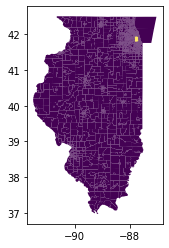

In [16]:
assignment = [ -1 for i in G.nodes ]
labeling = { i : 1 if x[i].x > 0.5 else 0 for i in G.nodes }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()

In [17]:
county_geoids = { G.nodes[i]['GEOID20'][0:5] for i in G.nodes }
county_pop = { g : 0 for g in county_geoids }

In [18]:
for i in labeling.keys():
    if labeling[i]==1:
        g = G.nodes[i]['GEOID20'][0:5]
        p = G.nodes[i]['TOTPOP']
        county_pop[g] += p

In [19]:
count = 0
print("geoid pop total_pop county")
for g in county_pop.keys():
    if county_pop[g]>0:
        i = gtn[g]
        print(g,county_pop[g],GC.nodes[i]['TOTPOP'],GC.nodes[i]['NAME20'],100*county_pop[g]/GC.nodes[i]['TOTPOP'])
        count += 1
print(count)

geoid pop total_pop county
17031 751591 5275541 Cook 14.246709484392216
1


In [20]:
nx.is_connected(G.subgraph(district))

True